In [9]:
import pandas as pd
import json
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, BertTokenizer
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns

In [10]:
df = pd.read_csv('ratebeer_subset.csv')
beer_style_encoder = LabelEncoder()
df['beer/style'] = beer_style_encoder.fit_transform(df['beer/style'])
df["review/time"] = pd.to_datetime(df["review/time"])
df["review/month"] = df["review/time"].dt.month

/tmp/ipykernel_2325100/3327210199.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ratebeer_subset.csv')


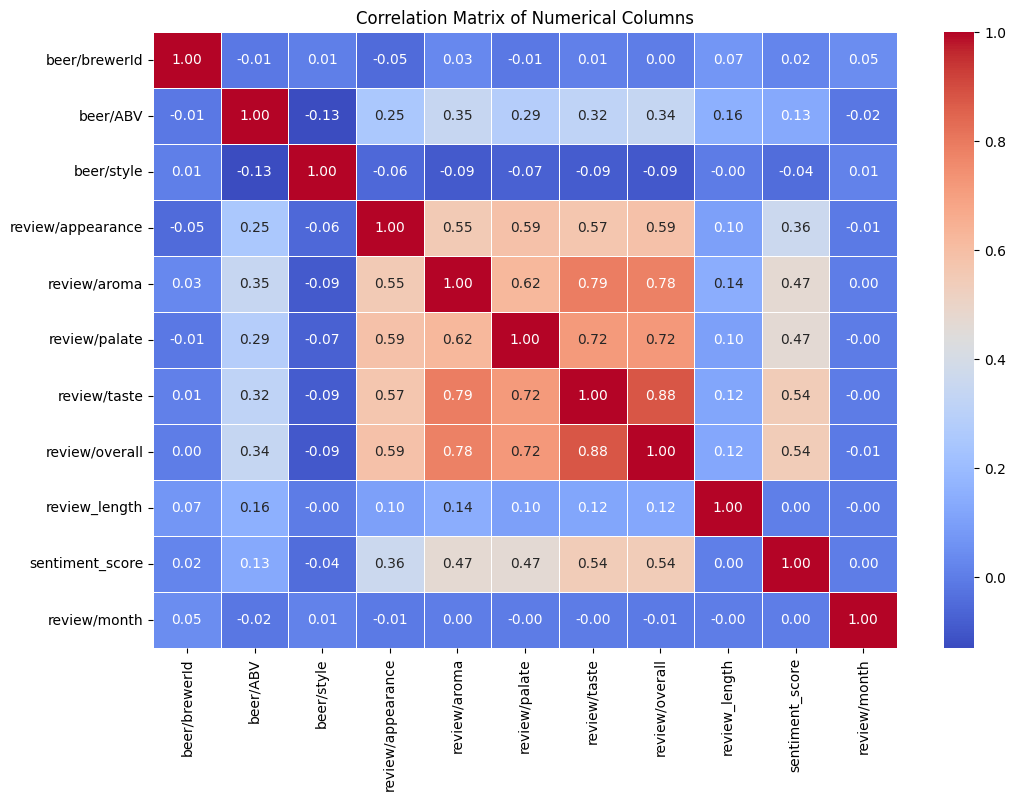

In [11]:
temp_df = df.drop(columns=['review/time', 'review/profileName', 'review/text', 'beer/name', 'beer/beerId'])
# Compute the correlation matrix
corr_matrix = temp_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

## Rating Prediction

In [12]:
# TODO: change column names
allRatings = []
for index, row in df.iterrows():
	user = row['review/profileName']
	item = row['beer/name']
	rating = row['review/overall']
	allRatings.append((user, item, rating))

In [13]:
# TODO: Change code here!
ratingsTrain, ratingsValid = train_test_split(allRatings, test_size=0.2, random_state=42)

print(f"Training set size: {len(ratingsTrain)}")
print(f"Validation set size: {len(ratingsValid)}")

Training set size: 400000
Validation set size: 100000


In [14]:
MSE = []
train_MSE = []
R2 = []
train_R2 = []
models = [
    "LFM",
	"Linear Regression", 
	"Lasso", 
	"Ridge", 
	"Decision Tree", 
	"Random Forest", 
	"Neural Network", 
	"Baseline Mean",
	"Baseline Median"
]

In [15]:
class RatingPredictionModelLFM:
	def __init__(self, mu, lamb):
		self.lamb = lamb
		self.alpha = mu
		self.beta_u = defaultdict(float)
		self.beta_i = defaultdict(float)
		self.ratingsPerUser = defaultdict(list)
		self.ratingsPerItem = defaultdict(list)

	def fit(self, ratingsTrain, ratingsValid, epochs=20):
		for u, i, r in ratingsTrain:
			self.ratingsPerUser[u].append((i, r))
			self.ratingsPerItem[i].append((u, r))

		# Iterative updates for biases
		for epoch in range(epochs):

			for u in self.ratingsPerUser:
				numerator = sum([r - self.alpha - self.beta_i[i] for i, r in self.ratingsPerUser[u]])
				denominator = self.lamb + len(self.ratingsPerUser[u])
				self.beta_u[u] = numerator / denominator

			for i in self.ratingsPerItem:
				numerator = sum([r - self.alpha - self.beta_u[u] for u, r in self.ratingsPerItem[i]])
				denominator = self.lamb + len(self.ratingsPerItem[i])
				self.beta_i[i] = numerator / denominator

			numerator = sum([r - self.beta_u[u] - self.beta_i[i] for u, i, r in ratingsTrain])
			self.alpha = numerator / len(ratingsTrain)

		loss = self.evaluate(ratingsValid)
		print(f"Final Validation Loss = {loss}")
		return loss

	def predict(self, user, item):
		bu = self.beta_u.get(user, 0)
		bi = self.beta_i.get(item, 0)
		return self.alpha + bu + bi

	def evaluate(self, ratingsValid):
		mse_valid = 0
		for u, i, r in ratingsValid:
			prediction = self.predict(u, i)
			mse_valid += (r - prediction) ** 2
		mse_valid /= len(ratingsValid)
		return mse_valid

In [16]:
min_loss = float('inf')
best_lambda = None

for lam in tqdm(np.arange(1, 9)):
	mu = np.mean([r for _, _, r in ratingsTrain])
	rating_model = RatingPredictionModelLFM(mu, lam)
	print("Lambda: ", lam)
	loss = rating_model.fit(ratingsTrain, ratingsValid)
	if loss < min_loss:
		min_loss = loss
		best_lambda = lam

print(f"Best lambda: {best_lambda}")
print(f"Minimum loss: {min_loss}")


min_loss = float('inf')

for lam in tqdm(np.arange(best_lambda, best_lambda+1, 0.1)):
	mu = np.mean([r for _, _, r in ratingsTrain])
	rating_model = RatingPredictionModelLFM(mu, lam)
	print("Lambda: ", lam)
	loss = rating_model.fit(ratingsTrain, ratingsValid)
	if loss < min_loss:
		min_loss = loss
		best_lambda = lam

print(f"Best lambda: {best_lambda}")
print(f"Minimum loss: {min_loss}")


min_loss = float('inf')

for lam in tqdm(np.arange(best_lambda, best_lambda+0.1, 0.01)):
	mu = np.mean([r for _, _, r in ratingsTrain])
	rating_model = RatingPredictionModelLFM(mu, lam)
	print("Lambda: ", lam)
	loss = rating_model.fit(ratingsTrain, ratingsValid)
	if loss < min_loss:
		min_loss = loss
		best_lambda = lam

print(f"Best lambda: {best_lambda}")
print(f"Minimum loss: {min_loss}")

  0%|          | 0/8 [00:00<?, ?it/s]

Lambda:  1


 12%|█▎        | 1/8 [00:17<01:59, 17.14s/it]

Final Validation Loss = 7.047087106285647
Lambda:  2


 25%|██▌       | 2/8 [00:33<01:41, 16.85s/it]

Final Validation Loss = 7.069993022173364
Lambda:  3


 38%|███▊      | 3/8 [00:50<01:23, 16.75s/it]

Final Validation Loss = 7.169695674471144
Lambda:  4


 50%|█████     | 4/8 [01:07<01:07, 16.82s/it]

Final Validation Loss = 7.282428740624495
Lambda:  5


 62%|██████▎   | 5/8 [01:23<00:50, 16.76s/it]

Final Validation Loss = 7.3926016870385745
Lambda:  6


 75%|███████▌  | 6/8 [01:40<00:33, 16.84s/it]

Final Validation Loss = 7.495927289207256
Lambda:  7


 88%|████████▊ | 7/8 [01:57<00:16, 16.72s/it]

Final Validation Loss = 7.591548549065499
Lambda:  8


100%|██████████| 8/8 [02:14<00:00, 16.79s/it]


Final Validation Loss = 7.679746042905343
Best lambda: 1
Minimum loss: 7.047087106285647


  0%|          | 0/10 [00:00<?, ?it/s]

Lambda:  1.0


 10%|█         | 1/10 [00:16<02:27, 16.42s/it]

Final Validation Loss = 7.047087106285647
Lambda:  1.1


 20%|██        | 2/10 [00:33<02:15, 16.91s/it]

Final Validation Loss = 7.040846937833614
Lambda:  1.2000000000000002


 30%|███       | 3/10 [00:50<01:59, 17.02s/it]

Final Validation Loss = 7.037456925219525
Lambda:  1.3000000000000003


 40%|████      | 4/10 [01:07<01:41, 16.96s/it]

Final Validation Loss = 7.036427099459933
Lambda:  1.4000000000000004


 50%|█████     | 5/10 [01:24<01:24, 16.98s/it]

Final Validation Loss = 7.03736554826117
Lambda:  1.5000000000000004


 60%|██████    | 6/10 [01:41<01:08, 17.04s/it]

Final Validation Loss = 7.03995506323568
Lambda:  1.6000000000000005


 70%|███████   | 7/10 [01:58<00:50, 16.94s/it]

Final Validation Loss = 7.043936219033963
Lambda:  1.7000000000000006


 80%|████████  | 8/10 [02:15<00:34, 17.04s/it]

Final Validation Loss = 7.0490948932704995
Lambda:  1.8000000000000007


 90%|█████████ | 9/10 [02:32<00:16, 16.94s/it]

Final Validation Loss = 7.055252913656065
Lambda:  1.9000000000000008


100%|██████████| 10/10 [02:53<00:00, 17.35s/it]


Final Validation Loss = 7.0622609470609135
Best lambda: 1.3000000000000003
Minimum loss: 7.036427099459933


  0%|          | 0/11 [00:00<?, ?it/s]

Lambda:  1.3000000000000003


  9%|▉         | 1/11 [00:17<02:55, 17.57s/it]

Final Validation Loss = 7.036427099459933
Lambda:  1.3100000000000003


 18%|█▊        | 2/11 [00:34<02:33, 17.09s/it]

Final Validation Loss = 7.036438127179686
Lambda:  1.3200000000000003


 27%|██▋       | 3/11 [00:51<02:17, 17.13s/it]

Final Validation Loss = 7.036468430669737
Lambda:  1.3300000000000003


 36%|███▋      | 4/11 [01:08<01:59, 17.01s/it]

Final Validation Loss = 7.036517671075333
Lambda:  1.3400000000000003


 45%|████▌     | 5/11 [01:25<01:42, 17.12s/it]

Final Validation Loss = 7.036585516533878
Lambda:  1.3500000000000003


 55%|█████▍    | 6/11 [01:42<01:24, 17.00s/it]

Final Validation Loss = 7.036671641996803
Lambda:  1.3600000000000003


 64%|██████▎   | 7/11 [01:59<01:07, 16.91s/it]

Final Validation Loss = 7.036775729056175
Lambda:  1.3700000000000003


 73%|███████▎  | 8/11 [02:16<00:50, 16.99s/it]

Final Validation Loss = 7.036897465776534
Lambda:  1.3800000000000003


 82%|████████▏ | 9/11 [02:33<00:33, 16.94s/it]

Final Validation Loss = 7.03703654653302
Lambda:  1.3900000000000003


 91%|█████████ | 10/11 [02:49<00:16, 16.90s/it]

Final Validation Loss = 7.037192671852379
Lambda:  1.4000000000000004


100%|██████████| 11/11 [03:06<00:00, 16.98s/it]

Final Validation Loss = 7.03736554826117
Best lambda: 1.3000000000000003
Minimum loss: 7.036427099459933


In [17]:
lam = best_lambda
# lam = 1.3
mu = np.mean([r for _, _, r in ratingsTrain])
rating_model = RatingPredictionModelLFM(mu, lam)
print("Lambda: ", lam)
mse = rating_model.fit(ratingsTrain, ratingsValid, epochs=50)
MSE.append(mse)

predictions = [rating_model.predict(u, i) for u, i, _ in ratingsValid]
r2 = r2_score([r for _, _, r in ratingsValid], predictions)
R2.append(r2)

mse_train = 0
for u, i, r in ratingsTrain:
	prediction = rating_model.predict(u, i)
	mse_train += (r - prediction) ** 2
train_MSE.append(mse_train / len(ratingsTrain))

predictions = [rating_model.predict(u, i) for u, i, _ in ratingsTrain]
r2_train = r2_score([r for _, _, r in ratingsTrain], predictions)
train_R2.append(r2_train)

print("Training Score")
print("LFM MSE: ", mse_train / len(ratingsTrain))
print("LFM R2: ", r2_train)
print("Validation Score")
print("LFM MSE: ", mse)
print("LFM R2: ", r2)

Lambda:  1.3000000000000003
Final Validation Loss = 7.018283093092164
Training Score
LFM MSE:  4.618211934729958
LFM R2:  0.644497523115821
Validation Score
LFM MSE:  7.018283093092164
LFM R2:  0.4580913092630282


In [18]:
df.drop(columns=[
    "review/text", 
	"review/time", 
	"review/profileName", 
	"beer/name", 
	"beer/beerId", 
	"beer/brewerId", 
	"beer/style", 
	"review_length",
	"review/month"], inplace=True)

y = df["review/overall"].values
df.drop(columns=["review/overall"], inplace=True)

scaler = StandardScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), columns=df.columns)

In [19]:
X = df.iloc[:, :].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
MSE.append(mse)
r2 = r2_score(y_test, y_pred)
R2.append(r2)

y_train_pred = linear_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
train_MSE.append(mse_train)
r2_train = r2_score(y_train, y_train_pred)
train_R2.append(r2_train)

print("Training Score")
print("Linear Regression MSE: ", mse_train)
print("Linear Regression R2: ", r2_train)
print("Validation Score")
print("Linear Regression MSE: ", mse)
print("Linear Regression R2: ", r2)

feature_importance = linear_model.coef_
features = list(df.columns)
print("Feature Importance: ", {features[i]: feature_importance[i] for i in range(len(features))})

lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
MSE.append(mse)
r2 = r2_score(y_test, y_pred)
R2.append(r2)

y_train_pred = lasso_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
train_MSE.append(mse_train)
r2_train = r2_score(y_train, y_train_pred)
train_R2.append(r2_train)

print("Training Score")
print("Lasso MSE: ", mse_train)
print("Lasso R2: ", r2_train)
print("Validation Score")
print("Lasso MSE: ", mse)
print("Lasso R2: ", r2)

feature_importance = lasso_model.coef_
features = list(df.columns)
print("Feature Importance: ", {features[i]: feature_importance[i] for i in range(len(features))})

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
MSE.append(mse)
r2 = r2_score(y_test, y_pred)
R2.append(r2)

y_train_pred = ridge_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
train_MSE.append(mse_train)
r2_train = r2_score(y_train, y_train_pred)
train_R2.append(r2_train)

print("Training Score")
print("Ridge MSE: ", mse_train)
print("Ridge R2: ", r2_train)
print("Validation Score")
print("Ridge MSE: ", mse)
print("Ridge R2: ", r2)

feature_importance = ridge_model.coef_
features = list(df.columns)
print("Feature Importance: ", {features[i]: feature_importance[i] for i in range(len(features))})

Training Score
Linear Regression MSE:  2.492369382870178
Linear Regression R2:  0.8081414405741316
Validation Score
Linear Regression MSE:  2.46880038975727
Linear Regression R2:  0.8093744055122124
Feature Importance:  {'beer/ABV': 0.13768213015027297, 'review/appearance': 0.20194857879495043, 'review/aroma': 0.6580954545423756, 'review/palate': 0.48024552711705726, 'review/taste': 1.9981299103769379, 'sentiment_score': 0.24831342390326844}
Training Score
Lasso MSE:  3.8232719148690295
Lasso R2:  0.7056907186705073
Validation Score
Lasso MSE:  3.8039421725735107
Lasso R2:  0.7062829619387391
Feature Importance:  {'beer/ABV': 0.0, 'review/appearance': 0.0, 'review/aroma': 0.2747606839106218, 'review/palate': 0.07068514563408071, 'review/taste': 1.8903362860028232, 'sentiment_score': 0.0}
Training Score
Ridge MSE:  2.4923693829236617
Ridge R2:  0.8081414405700145
Validation Score
Ridge MSE:  2.4688004006164777
Ridge R2:  0.8093744046737311
Feature Importance:  {'beer/ABV': 0.13768278884

In [21]:

decision_tree = DecisionTreeRegressor(random_state=42, max_depth=10)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
MSE.append(mse)
r2 = r2_score(y_test, y_pred)
R2.append(r2)

y_train_pred = decision_tree.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
train_MSE.append(mse_train)
r2_train = r2_score(y_train, y_train_pred)
train_R2.append(r2_train)

print("Training Score")
print("Decision Tree MSE: ", mse_train)
print("Decision Tree R2: ", r2_train)
print("Validation Score")
print("Decision Tree MSE: ", mse)
print("Decision Tree R2: ", r2)

feature_importance = decision_tree.feature_importances_
features = list(df.columns)
print("Feature Importance: ", {features[i]: feature_importance[i] for i in range(len(features))})

random_forest = RandomForestRegressor(n_estimators=15, random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
MSE.append(mse)
r2 = r2_score(y_test, y_pred)
R2.append(r2)

y_train_pred = random_forest.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
train_MSE.append(mse_train)
r2_train = r2_score(y_train, y_train_pred)
train_R2.append(r2_train)

print("Training Score")
print("Random Forest MSE: ", mse_train)
print("Random Forest R2: ", r2_train)
print("Validation Score")
print("Random Forest MSE: ", mse)
print("Random Forest R2: ", r2)

feature_importance = random_forest.feature_importances_
features = list(df.columns)
print("Feature Importance: ", {features[i]: feature_importance[i] for i in range(len(features))})

Training Score
Decision Tree MSE:  2.3261451191729567
Decision Tree R2:  0.8209371152416838
Validation Score
Decision Tree MSE:  2.3931355922922948
Decision Tree R2:  0.8152167761868124
Feature Importance:  {'beer/ABV': 0.005020666332421584, 'review/appearance': 0.003423552379229404, 'review/aroma': 0.022034976023249032, 'review/palate': 0.023874830767674635, 'review/taste': 0.9399827862295921, 'sentiment_score': 0.005663188267833174}
Training Score
Random Forest MSE:  1.7385520664424843
Random Forest R2:  0.8661690770047885
Validation Score
Random Forest MSE:  2.675723794451189
Random Forest R2:  0.7933970518157099
Feature Importance:  {'beer/ABV': 0.04932437037324714, 'review/appearance': 0.012949848319044567, 'review/aroma': 0.02853464850765718, 'review/palate': 0.02459199447483657, 'review/taste': 0.8706190168034623, 'sentiment_score': 0.013980121521752164}


In [22]:
mlp = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=20, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
MSE.append(mse)
r2 = r2_score(y_test, y_pred)
R2.append(r2)

y_train_pred = mlp.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
train_MSE.append(mse_train)
r2_train = r2_score(y_train, y_train_pred)
train_R2.append(r2_train)

print("Training Score")
print("Neural Network MSE: ", mse_train)
print("Neural Network R2: ", r2_train)
print("Validation Score")
print("Neural Network MSE: ", mse)
print("Neural Network R2: ", r2)

/data/yashowardhan/miniforge3/envs/world_model_datasets/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Score
Neural Network MSE:  2.35932142911342
Neural Network R2:  0.8183832566218537
Validation Score
Neural Network MSE:  2.34778930719522
Neural Network R2:  0.8187181376538253


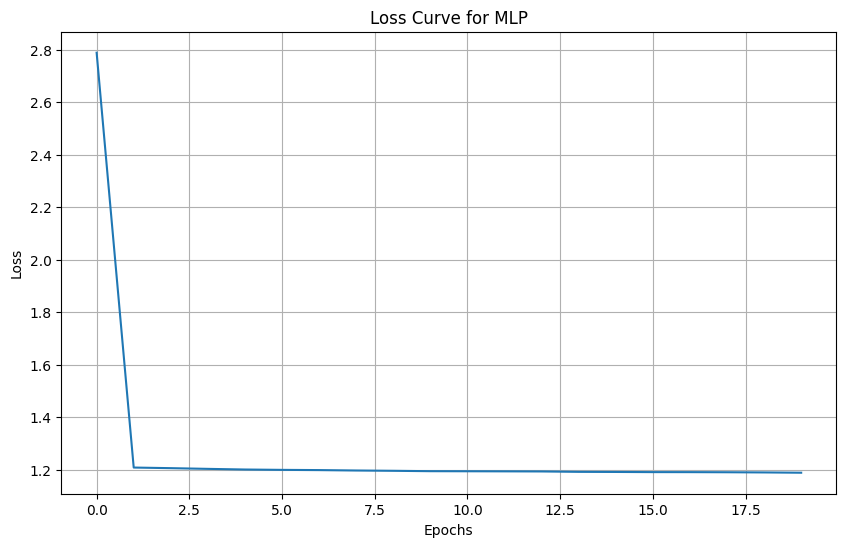

In [23]:
losses = mlp.loss_curve_
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Loss Curve for MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [24]:
# Baseline Mean Model
baseline_mse = np.mean((y_test - np.mean(y_train)) ** 2)
MSE.append(baseline_mse)
baseline_r2 = r2_score(y_test, [np.mean(y_train) for _ in range(len(y_test))])
R2.append(baseline_r2)
train_baseline_mse = np.mean((y_train - np.mean(y_train)) ** 2)
train_MSE.append(train_baseline_mse)
train_baseline_r2 = r2_score(y_train, [np.mean(y_train) for _ in range(len(y_train))])
train_R2.append(train_baseline_r2)

print("Training Score")
print("Baseline MSE: ", train_baseline_mse)
print("Baseline R2: ", train_baseline_r2)
print("Validation Score")
print("Baseline MSE: ", baseline_mse)
print("Baseline R2: ", baseline_r2)

# Baseline Model Median
baseline_median_mse = np.mean((y_test - np.median(y_train)) ** 2)
MSE.append(baseline_median_mse)
predictor = np.median(y_train)
baseline_median_r2 = r2_score(y_test, [predictor for _ in range(len(y_test))])
R2.append(baseline_median_r2)
train_baseline_median_mse = np.mean((y_train - np.median(y_train)) ** 2)
train_MSE.append(train_baseline_median_mse)
predictor = np.median(y_train)
train_baseline_median_r2 = r2_score(y_train, [predictor for _ in range(len(y_train))])
train_R2.append(train_baseline_median_r2)

print("Training Score")
print("Baseline MSE: ", train_baseline_median_mse)
print("Baseline R2: ", train_baseline_median_mse)
print("Validation Score")
print("Baseline Median MSE: ", baseline_median_mse)
print("Baseline Median R2: ", baseline_median_r2)


Training Score
Baseline MSE:  12.990660361093745
Baseline R2:  0.0
Validation Score
Baseline MSE:  12.951101040906252
Baseline R2:  -4.433504196876825e-06
Training Score
Baseline MSE:  12.9965375
Baseline R2:  12.9965375
Validation Score
Baseline Median MSE:  12.95814
Baseline Median R2:  -0.000547938668643333


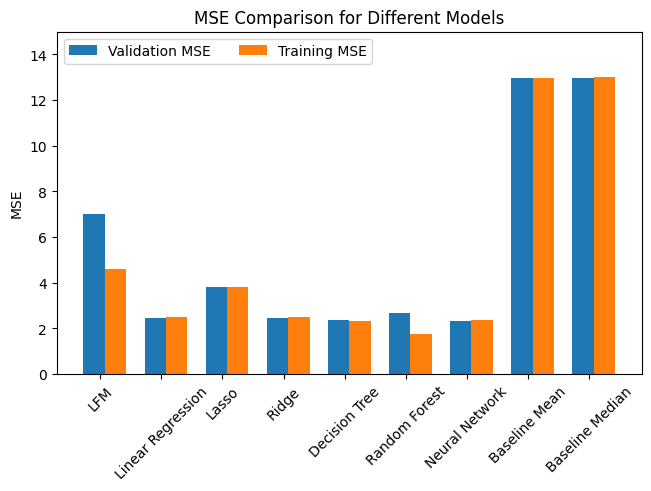

In [25]:

results = {
	"Validation MSE": MSE,
	"Training MSE": train_MSE,
}

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in results.items():
    offset = width * multiplier + 0.25
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3, fmt='%.4f')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('MSE Comparison for Different Models')
ax.set_xticks(x + width, models, rotation=45)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 15)

plt.show()

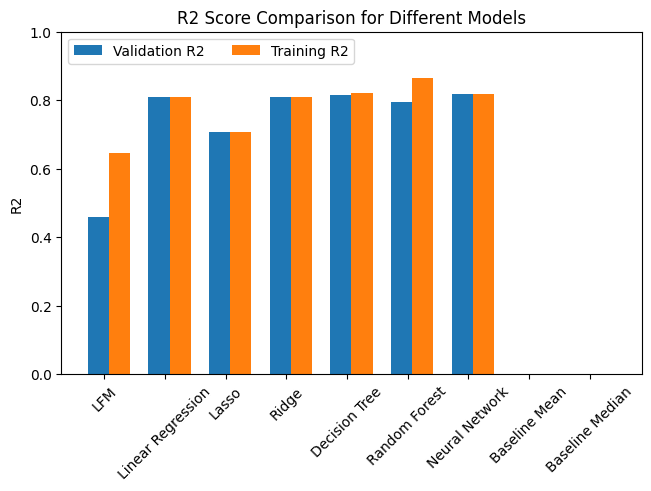

In [26]:
results = {
    "Validation R2": R2,
	"Training R2": train_R2
}

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in results.items():
    offset = width * multiplier + 0.25
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3, fmt='%.4f')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('R2')
ax.set_title('R2 Score Comparison for Different Models')
ax.set_xticks(x + width, models, rotation=45)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()


In [27]:
print("Best Model: ", models[np.argmin(MSE)])
print("Best Model MSE: ", np.min(MSE))
print()
for i in range(len(models)):
	print(f"Model: {models[i]}")
	print(f"Training MSE: {train_MSE[i]}")
	print(f"Validation MSE: {MSE[i]}")
	print(f"Training R2: {train_R2[i]}")
	print(f"Validation R2: {R2[i]}")
	print()

Best Model:  Neural Network
Best Model MSE:  2.34778930719522

Model: LFM
Training MSE: 4.618211934729958
Validation MSE: 7.018283093092164
Training R2: 0.644497523115821
Validation R2: 0.4580913092630282

Model: Linear Regression
Training MSE: 2.492369382870178
Validation MSE: 2.46880038975727
Training R2: 0.8081414405741316
Validation R2: 0.8093744055122124

Model: Lasso
Training MSE: 3.8232719148690295
Validation MSE: 3.8039421725735107
Training R2: 0.7056907186705073
Validation R2: 0.7062829619387391

Model: Ridge
Training MSE: 2.4923693829236617
Validation MSE: 2.4688004006164777
Training R2: 0.8081414405700145
Validation R2: 0.8093744046737311

Model: Decision Tree
Training MSE: 2.3261451191729567
Validation MSE: 2.3931355922922948
Training R2: 0.8209371152416838
Validation R2: 0.8152167761868124

Model: Random Forest
Training MSE: 1.7385520664424843
Validation MSE: 2.675723794451189
Training R2: 0.8661690770047885
Validation R2: 0.7933970518157099

Model: Neural Network
Training